# Yonda and Cyclescheme - Sentiment


Below is an analysis using Twitter and Facebook for a month's period. Looking into Page Ratings on FB, weekly tweets related to cyclescheme ie. #cyclescheme @cycleschemeltd etc. Another git repo details the social netowrk analysis week by week and builds a visualisation of the results. 

It later goes on to the cyclescheme inbox to show how we can model conversations and pull out artifactrs with NER and deciphers core topics that are mentioned by users

# Import Modules

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import tweepy
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import json
import datetime
import glob
import csv
import time
import pandas as pd
from tweepy import OAuthHandler
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from notebook_settings import settings as s
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
from vaderSentiment import vaderSentiment

try:
    from urllib.request import urlopen, Request
except ImportError:
    from urllib2 import urlopen, Request

### Credentials for the APIs

In [ ]:
# Twitter credentials
consumer_key = s.TWITTER_CONSUMER_KEY
consumer_secret = s.TWITTER_CONSUMER_SECRET
access_token = s.TWITTER_ACCESS_TOKEN
access_token_secret = s.TWITTER_ACCESS_TOKEN_SECRET

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [ ]:
# Facebook Credentials
app_id = s.FACEBOOK_APP_ID
app_secret = s.FACEBOOK_APP_SECRET
fb_access_token_cs = s.FACEBOOK_ACCESS_TOKEN_CS
fb_access_token_yn = s.FACEBOOK_ACCESS_TOKEN_YN
extended_fb_token_cs = s.FACEBOOK_ACCESS_TOKEN_CS_EXT
page_id_cs = "175726642454615"
page_id_yn = "524967997939518"

In [ ]:
# input date formatted as YYYY-MM-DD
since_date = ""
until_date = ""

Facebook's Pages need more permissions to acces public conentent for Pages. Need to be a Business Account Manager admin 
Response
```  {
    "error": {
      "message": "(#10) To use 'Page Public Content Access', your use of this endpoint must be reviewed and approved by Facebook. To submit this 'Page Public Content Access' feature for review please read our documentation on reviewable features: https://developers.facebook.com/docs/apps/review.",
      "type": "OAuthException",
      "code": 10,
      "fbtrace_id": "D91l+9L9575"
    }
  }
  ```
  
Also tokens expire in 2 hours, need to get an extended page access token.

# Collect Data

In [ ]:
# generate extended access token key for app - only required once
from facepy import get_extended_access_token

extended_fb_token_cs = get_extended_access_token(fb_access_token_cs, app_id, app_secret)

### Gather Facebook Page Ratings/Reviews Cyclescheme

In [ ]:
# test out access token

def testFacebookPageData(page_id, access_token):
    
    # construct the URL string
    base = "https://graph.facebook.com/v2.4"
    node = "/" + page_id
    parameters = "/?access_token=%s" % access_token
    url = base + node + parameters
    
    # retrieve data
    req = requests.get(url)
    response = req.text
    
    print(response)
    

testFacebookPageData(page_id_cs, fb_access_token_cs)

In [ ]:
# main functions for ratings for yonda and cyclescheme
# TODO: put in a class
def request_until_succeed(url):
    req = Request(url)
    success = False
    while success is False:
        try:
            response = urlopen(req)
            if response.getcode() == 200:
                success = True
        except Exception as e:
            print(e)
            time.sleep(5)

            print("Error for URL {}: {}".format(url, datetime.datetime.now()))
            print("Retrying.")

    return response.read()


# Needed to write tricky unicode correctly to csv
def unicode_decode(text):
    try:
        return text.encode('utf-8').decode()
    except UnicodeDecodeError:
        return text.encode('utf-8')


def getFacebookPageFeedUrl(base_url):

    # Construct the URL string; see http://stackoverflow.com/a/37239851 for
    # Reactions parameters
    fields = "&fields=message,link,created_time,type,name,id," + \
        "comments.limit(0).summary(true),shares,reactions" + \
        ".limit(0).summary(true)"
    print(base_url + fields)

    return base_url + fields


def getReactionsForStatuses(base_url):

    reaction_types = ['like', 'love', 'wow', 'haha', 'sad', 'angry']
    reactions_dict = {}   # dict of {status_id: tuple<6>}

    for reaction_type in reaction_types:
        fields = "&fields=reactions.type({}).limit(0).summary(total_count)".format(
            reaction_type.upper())

        url = base_url + fields

        data = json.loads(request_until_succeed(url))['data']

        data_processed = set()  # set() removes rare duplicates in statuses
        for status in data:
            id = status['id']
            count = status['reactions']['summary']['total_count']
            data_processed.add((id, count))

        for id, count in data_processed:
            if id in reactions_dict:
                reactions_dict[id] = reactions_dict[id] + (count,)
            else:
                reactions_dict[id] = (count,)

    return reactions_dict


def processFacebookPageFeedStatus(status):

    # The status is now a Python dictionary, so for top-level items,
    # we can simply call the key.

    # Additionally, some items may not always exist,
    # so must check for existence first

    status_id = status['id']
    status_type = status['type']

    status_message = '' if 'message' not in status else \
        unicode_decode(status['message'])
    link_name = '' if 'name' not in status else \
        unicode_decode(status['name'])
    status_link = '' if 'link' not in status else \
        unicode_decode(status['link'])

    # Time needs special care since a) it's in UTC and
    # b) it's not easy to use in statistical programs.

    status_published = datetime.datetime.strptime(
        status['created_time'], '%Y-%m-%dT%H:%M:%S+0000')
    status_published = status_published.strftime(
        '%Y-%m-%d %H:%M:%S')  # best time format for spreadsheet programs

    # Nested items require chaining dictionary keys.

    num_reactions = 0 if 'reactions' not in status else \
        status['reactions']['summary']['total_count']
    num_comments = 0 if 'comments' not in status else \
        status['comments']['summary']['total_count']
    num_shares = 0 if 'shares' not in status else status['shares']['count']

    return (status_id, status_message, link_name, status_type, status_link,
            status_published, num_reactions, num_comments, num_shares)


def scrapeFacebookPageFeedStatus(page_id, access_token, since_date, until_date):
    with open('{}_facebook_statuses.csv'.format(page_id), 'w', encoding='utf-8', newline='') as file:
        w = csv.writer(file)
        w.writerow(["status_id", "status_message", "link_name", "status_type",
                    "status_link", "status_published", "num_reactions",
                    "num_comments", "num_shares", "num_likes", "num_loves",
                    "num_wows", "num_hahas", "num_sads", "num_angrys",
                    "num_special"])

        has_next_page = True
        num_processed = 0
        scrape_starttime = datetime.datetime.now()
        after = ''
        base = "https://graph.facebook.com/v3.2"
        node = "/{}/posts".format(page_id)
        parameters = "/?limit={}&access_token={}".format(100, access_token)
        since = "&since={}".format(since_date) if since_date \
            is not '' else ''
        until = "&until={}".format(until_date) if until_date \
            is not '' else ''

        print("Scraping {} Facebook Page: {}\n".format(page_id, scrape_starttime))

        while has_next_page:
            after = '' if after is '' else "&after={}".format(after)
            base_url = base + node + parameters + after + since + until

            url = getFacebookPageFeedUrl(base_url)
            statuses = json.loads(request_until_succeed(url))
            reactions = getReactionsForStatuses(base_url)

            for status in statuses['data']:

                # Ensure it is a status with the expected metadata
                if 'reactions' in status:
                    status_data = processFacebookPageFeedStatus(status)
                    reactions_data = reactions[status_data[0]]

                    # calculate thankful/pride through algebra
                    num_special = status_data[6] - sum(reactions_data)
                    w.writerow(status_data + reactions_data + (num_special,))

                num_processed += 1
                if num_processed % 100 == 0:
                    print("{} Statuses Processed: {}".format
                          (num_processed, datetime.datetime.now()))

            # if there is no next page, we're done.
            if 'paging' in statuses:
                after = statuses['paging']['cursors']['after']
            else:
                has_next_page = False

        print("\nDone!\n{} Statuses Processed in {}".format(
              num_processed, datetime.datetime.now() - scrape_starttime))


if __name__ == '__main__':
    scrapeFacebookPageFeedStatus(page_id_yn, fb_access_token_yn, since_date, until_date)

### Gather all Messages in Inbox Cyclescheme

In [ ]:
from pprint import pprint
# collect all messages functions
def request_until_succeed(url):
    req = Request(url)
    success = False
    while success is False:
        try:
            response = urlopen(req)
            if response.getcode() == 200:
                success = True
        except Exception as e:
            print(e)
            time.sleep(5)

            print("Error for URL {}: {}".format(url, datetime.datetime.now()))
            print("Retrying.")

    return response.read()


# Needed to write tricky unicode correctly to csv
def unicode_decode(text):
    try:
        return text.encode('utf-8').decode()
    except UnicodeDecodeError:
        return text.encode('utf-8')


def get_facebook_inbox_url(base_url):

    # Construct the URL string; see http://stackoverflow.com/a/37239851 for
    # Reactions parameters
    fields = "&fields=messages{message,from,to,created_time}"
    
    return base_url + fields

def process_facebook_messages(message):

    # The message is now a Python dictionary, so for top-level items,
    # we can simply call the key.

    # Additionally, some items may not always exist,
    # so must check for existence first

    message_id = message['id']
    print(message_id)
    message_from = message['from']['name']
    message_to = message['to']['data'][0]['name']
    message_text = unicode_decode(message['message'])

    # Time needs special care since a) it's in UTC and
    # b) it's not easy to use in statistical programs.

    message_published = datetime.datetime.strptime(
        message['created_time'], '%Y-%m-%dT%H:%M:%S+0000')
    # best time format for spreadsheet programs
    message_published = message_published.strftime('%Y-%m-%d %H:%M:%S')  


    return (message_id,
            message_to,
            message_from,
            message_published, 
            message_text
            ) 

def scrape_facebook_inbox(page_id, access_token, since_date, until_date):
    with open('{}_facebook_inbox.csv'.format(page_id), 'w', encoding='utf-8', newline='') as file:
        w = csv.writer(file)
        w.writerow(["message_id", "to", "from", "created_time", "message_text"])

        has_next_page = True
        num_processed = 0
        scrape_starttime = datetime.datetime.now()
        after = ''
        base = "https://graph.facebook.com/v3.2"
        node = "/{}/conversations".format(page_id)
        parameters = "/?limit={}&access_token={}".format(100, access_token)
        since = "&since={}".format(since_date) if since_date \
            is not '' else ''
        until = "&until={}".format(until_date) if until_date \
            is not '' else ''

        print("Scraping {} Facebook Inbox: {}\n".format(page_id, scrape_starttime))

        while has_next_page:
            after = '' if after is '' else "&after={}".format(after)
            base_url = base + node + parameters + after + since + until

            url = get_facebook_inbox_url(base_url)
            print(url)
            conversations = json.loads(request_until_succeed(url))
                
            # get message details 
            for messages in conversations['data']:
                for message in messages['messages']['data']:
                    message_data = process_facebook_messages(message)
                    w.writerow(message_data)
                    num_processed += 1
                    if num_processed % 100 == 0:
                        print("{} Messages Processed: {}".format
                              (num_processed, datetime.datetime.now()))

            # if there is no next page, we're done.
            if 'paging' in conversations:
                after = conversations['paging']['cursors']['after']
            else:
                has_next_page = False

        print("\nDone!\n{} Messages Processed in {}".format(
              num_processed, datetime.datetime.now() - scrape_starttime))


if __name__ == '__main__':
    scrape_facebook_inbox(page_id_cs, extended_fb_token_cs, since_date, until_date)

### Gather Tweet Data for Cyclescheme

In [ ]:
class TwitterClient(object): 
    """ 
    Generic Twitter Class for sentiment analysis. 
    """
    def __init__(self): 
        """ 
        Class constructor or initialization method. 
        """
        # keys and tokens from the Twitter Dev Console 
        consumer_key = s.TWITTER_CONSUMER_KEY
        consumer_secret = s.TWITTER_CONSUMER_SECRET
        access_token = s.TWITTER_ACCESS_TOKEN
        access_token_secret = s.TWITTER_ACCESS_TOKEN_SECRET
  
        # attempt authentication 
        try: 
            # create OAuthHandler object 
            self.auth = OAuthHandler(consumer_key, consumer_secret) 
            # set access token and secret 
            self.auth.set_access_token(access_token, access_token_secret) 
            # create tweepy API object to fetch tweets 
            self.api = tweepy.API(self.auth) 
        except: 
            print("Error: Authentication Failed") 
  
    def clean_tweet(self, tweet): 
        
        """ 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        """
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    
#     def sentiment_analysis_vader(self, text):
#         analyzer = SentimentIntensityAnalyzer()
#         sentiment_dict = analyzer.polarity_scores((self.clean_tweet(tweet))
                                                  
#         print("Overall sentiment dictionary is : ", sentiment_dict) 
#         print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
#         print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
#         print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
        
#         # set sentiment 
#         if sentiment_dict['compound'] >= 0.05 : 
#             print("Positive") 
  
#         elif sentiment_dict['compound'] <= - 0.05 : 
#             print("Negative") 
  
#         else : 
#             print("Neutral") 
  
    def get_tweet_sentiment_blob(self, tweet): 
        
        """ 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        """
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(self.clean_tweet(tweet)) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'
  
    def get_tweets(self, query, count = 100): 
        
        """ 
        Main function to fetch tweets and parse them. 
        """
        # empty list to store parsed tweets 
        tweets = []
  
        try: 
            # call twitter api to fetch tweets 
            fetched_tweets = self.api.search(q = query, count = count, tweet_mode='extended') 
  
            # parsing tweets one by one 
            for tweet in fetched_tweets: 
                # empty dictionary to store required params of a tweet 
                parsed_tweet = {}
                
                # saving text of tweet 
                parsed_tweet['text'] = tweet.full_text 
                # saving sentiment of tweet 
                parsed_tweet['sentiment'] = self.get_tweet_sentiment_blob(tweet.full_text)
              #  parsed_tweet['sentiment_vader'] = self.get_tweet_sentiment_vader(tweet.full_text)
                
                # add data to dataframe
                parsed_tweet.update({
                u'tweet_id': tweet.id,
                u'created_at': tweet.created_at,
                u'user_name': tweet.user.name,
                u'followers_count': tweet.user.followers_count,
                u'favourites_count': tweet.user.favourites_count,
                u'retweet_count': tweet.retweet_count,
                u'friends_count': tweet.user.friends_count})
  
                # appending parsed tweet to tweets list 
                if tweet.retweet_count > 0: 
                    # if tweet has retweets, ensure that it is appended only once 
                    if parsed_tweet not in tweets: 
                        tweets.append(parsed_tweet) 
                else: 
                    tweets.append(parsed_tweet)
                               
            # return parsed tweets 
            return tweets
  
        except tweepy.TweepError as e: 
            # print error (if any) 
            print("Error : " + str(e)) 

def main(): 
    # creating object of TwitterClient Class 
    api = TwitterClient() 
    # calling function to get tweets 
    tweets = api.get_tweets(query = '@cycleschemeltd OR #cycleschemeltd OR cycleschemeltd', count = 1000) 
  
    # picking positive tweets from tweets 
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive'] 
    # percentage of positive tweets 
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
    # picking negative tweets from tweets 
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative'] 
    # percentage of negative tweets 
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets))) 
    # percentage of neutral tweets
    neutweets = len(tweets) - len(ptweets) - len(ntweets)
    print("Neutral tweets percentage: {} %".format(100*neutweets/len(tweets))) 
    # print number of tweets 
    print("Total tweet count: ", len(tweets))
    data = pd.DataFrame(tweets)
    data.to_csv('tweets.csv', header=True, encoding='utf-8')
    print('Tweets saved to file')
    
  
    # printing first 5 positive tweets 
    print("\n\nPositive tweets:") 
    for tweet in ptweets[:10]:
        print(tweet['text']) 
  
    # printing first 5 negative tweets 
    print("\n\nNegative tweets:") 
    for tweet in ntweets[:10]:
        print(tweet['text']) 

if __name__ == "__main__": 
    # calling main function 
    main() 

### Gather Facebook Page Insight Data

In [ ]:
# this is no longer possible unless the user provides specific permission to the app that they are ok to share their data with you

# From http://stackoverflow.com/a/312467
def split_seq(iterable, size):
    it = iter(iterable)
    item = list(itertools.islice(it, size))
    while item:
        yield item
        item = list(itertools.islice(it, size))


# Clear screen
os.system('cls' if os.name == 'nt' else 'clear')

graph = nx.Graph()
base_url = 'https://graph.facebook.com/v1.0/' + group + '/members'

# How to get an infinite access token, otherwise our analysis takes too long
#
# Go to https://developers.facebook.com/tools/explorer/ to get the normal access token
#
# as said here: https://developers.facebook.com/docs/facebook-login/access-tokens/#extending
#
# Create an application and get API key and secret, and do this:
#
# GET /oauth/access_token?
#    grant_type=fb_exchange_token&
#    client_id={app-id}&
#    client_secret={app-secret}&
#    fb_exchange_token={short-lived-token}
#
# This is done by the following code:
#

base_url0 = 'https://graph.facebook.com/oauth/access_token?grant_type=fb_exchange_token&client_id=%s&client_secret=%s&fb_exchange_token=%s' % \
            (client_id, client_secret, ACCESS_TOKEN,)
message = requests.get(base_url0)
message1 = message.content[13:]
INFINITE_TOKEN = message1[:message1.find("&expires=")]
print "The infinite token is:", INFINITE_TOKEN

# Get only the ID of the group users in order to get all of them
fields = '&fields=id&limit=5000'
url = '%s?fields=%s&access_token=%s' % \
      (base_url, fields, INFINITE_TOKEN)

# Interpret the response as JSON and convert back
# to Python data structures
print ""
print "Talking to the API..."
content = requests.get(url).json()

print ""
print "Getting all the users..."

end_point = "https://graph.facebook.com/v1.0/"

batch_request = ""

users = []

newpage = {}
i = 0
newpage[0] = requests.get(url).json()

while 1 > 0:
    print "-----------------------------------------"
    print "Reading page n.", i, "from the Facebook API..."
    print ""
    if i != 0:
        newpage[i] = requests.get(newpage[i - 1]["paging"]["next"]).json()
    if len(newpage[i]["data"]) == 0:
        print "Got all the data."
        break
    if "paging" in newpage[i].keys():
        for w, x in enumerate(newpage[i]["data"]):
            users.append(x)

    i = i + 1

print ""
print "There are", len(users), "users."

# Get the users and the connections between the users
for i, k in enumerate(users):
    base_url3 = 'https://graph.facebook.com/v1.0/' + k["id"]
    fields3 = '&limit=2000'
    url3 = '%s?fields=%s&access_token=%s' % (base_url3, fields3, INFINITE_TOKEN)

    try:
        firstname = requests.get(url3).json()
    except:
        name1 = requests.get(url3)
        firstname = json.loads(name1.text.strip("'<>() ").replace('\'', '\"'))

    if "error" in firstname:
        # Check if we reached the API limit
        if firstname["error"]["message"] == "User request limit reached.":
            # Wait 30 minutes if we reach the user limit
            # See https://developers.facebook.com/docs/reference/ads-api/api-rate-limiting/
            print ""
            print "There was an error. Waiting 30 minutes before starting again..."
            sleep(60 * 30)
            firstname = requests.get(url3).json()
        # Check if we got another error which I haven't understood yet ...
        elif firstname["error"]["message"] == "Unsupported get request.":
            print ""
            print "There is an error with this user."

    else:

        # Print debug information
        print ""
        print "----------------------"
        print ""
        X = firstname["name"].encode("utf-8")
        print "New user:", X
        print
        # Debug
        # print firstname

        # Add node with gender data
        if X not in graph.nodes():
            graph.add_node(X)
        if "gender" in firstname:
            graph.node[X]['gender'] = firstname["gender"]
            print X, "is a", graph.node[X]['gender']
        else:
            graph.node[X]['gender'] = "None"

        # Check friendships with the other members of the group:
        # Creating requests
        all_requests = []
        for j, m in enumerate(users):
            single_request = {'method': 'GET', 'relative_url': k['id'] + '/friends/' + m['id']}
            all_requests.append(single_request)

    # Making batch requests
    # https://developers.facebook.com/docs/graph-api/making-multiple-requests/
    # Split the list of requests in blocks of 50 requests, the limit for batch requests
    chunks = split_seq(all_requests, 50)

    for u in chunks:
        batch_request = json.dumps(u)
        try:
            facebook_request = requests.post(end_point, params={'access_token': INFINITE_TOKEN, 'batch': batch_request})
        # result_string = json.loads(facebook_request.text.strip("'<>() ").replace('\'', '\"'))
        except:
            print ""
            print "There was an error. Waiting 30 minutes before starting again..."
            sleep(60 * 30)
            facebook_request = requests.post(end_point, params={'access_token': INFINITE_TOKEN, 'batch': batch_request})
        try:
            result_string = json.loads(facebook_request.text)
        except:
            print "There was an error n decoding the JSON data"
            result_string = "error"

        if "error" in result_string:
            # Wait 30 minutes if we reach the user limit
            # See https://developers.facebook.com/docs/reference/ads-api/api-rate-limiting/
            print ""
            print "There was an error. Waiting 30 minutes before starting again..."
            sleep(60 * 30)

            facebook_request = requests.post(end_point, params={'access_token': INFINITE_TOKEN, 'batch': batch_request})
            result_string = json.loads(facebook_request.text)

        for z in result_string:
            if z is not None and z["body"] is not None:
                result_dict = json.loads(z["body"])
                # Debug
                # print result_dict
                if "data" in result_dict and len(result_dict["data"]) != 0:
                    for t in result_dict["data"]:
                        Y = t["name"].encode("utf-8")
                        print "- Friend with", Y
                        graph.add_edge(X, Y)

# Save the file and exit
print ""
print "The group was analyzed succesfully."
print ""
print "Saving the file as " + group + "-friendships.gexf..."
nx.write_gexf(graph, group + "-friendships.gexf")

# Analysis

### Sentiment of Twitter Tweets

In [2]:
# Load csv files into dataframe
def read_files(folder_path):
    """"
    Read in files from folder_path
    :param folder_path: str folder containing raw csv files
    :return: obj dataframe of csv file concatenation
    """
    print('Reading csv files from: %s' % folder_path)
    path = str(folder_path)
    # fields = ['']  # todo: check columns exist
    all_files = glob.glob(os.path.join(path, 'tweets*.csv'))
    num_files = len(all_files)
    print('Number of files in folder: %s' % num_files)
    data = pd.concat((pd.read_csv(file, encoding='utf-8', 
                                  # usecols=fields, 
                                  sep=',') for file in all_files))
    print('Length of combined csv files: %s' % len(data))
    data.index = pd.RangeIndex(len(data.index))
    # todo: handle exception
    # import codecs
    # try:
    #     f = codecs.open(filename, encoding='utf-8', errors='strict')
    #     for line in f:
    #         pass
    #     print "Valid utf-8"
    # except UnicodeDecodeError:
    #     print "invalid utf-8"

    print('Dataframe loaded!')
    return data

In [3]:
# df = read_files("E:\\Users\\Lee Joshi-Jones\\Documents\\GitHub\\HawkSense\\data")
df = read_files("C:\\Users\\ljosh00-aa\\GitHub\\HawkSense\\data")

Reading csv files from: C:\Users\ljosh00-aa\GitHub\HawkSense\data
Number of files in folder: 4
Length of combined csv files: 324
Dataframe loaded!


In [4]:
# remove the first colum
df = df.iloc[:, 1:]

# drop other columns that aren't needed
df = df.drop(columns=['tweet_id'])

In [5]:
df.head()

,created_at,favourites_count,followers_count,friends_count,retweet_count,sentiment,text,user_name
0,2019-04-03 13:57:22,8052,7625,5559,1,positive,RT @BenefitsEvery1: Chance to win £3000 with @...,Love to Ride
1,2019-04-03 13:27:33,122,116,207,1,positive,Chance to win £3000 with @cycleschemeltd and @...,Benefits Everyone
2,2019-04-03 11:48:24,806,123,402,0,negative,RT @cycleschemeltd: During British Summer Time...,Open Scarborough
3,2019-04-03 11:46:14,122,116,207,1,negative,RT @cycleschemeltd: Exercise and Mental Health...,Benefits Everyone
4,2019-04-03 05:58:02,2555,30937,6102,1,negative,Exercise and Mental Health: What you Need to K...,Cyclescheme


In [6]:
df['pre_clean_len'] = [len(t) for t in df['text']]

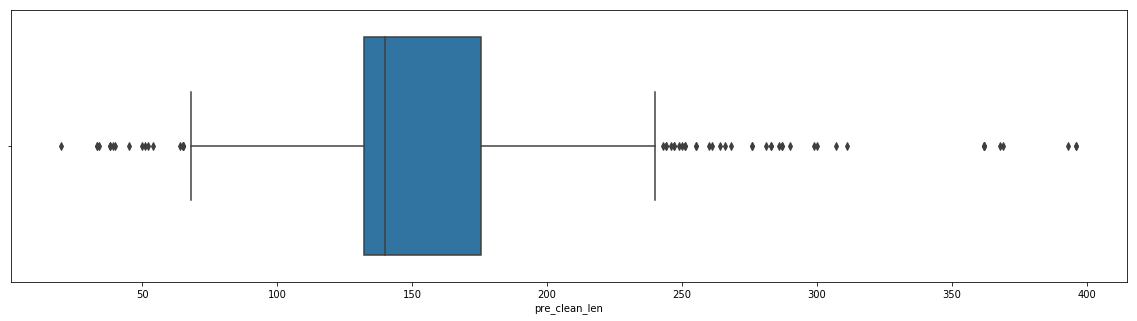

In [7]:
# overall distribution of tweet length
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(df['pre_clean_len'])
plt.show()

In [11]:
df[df.pre_clean_len > 140].head(10)

,created_at,favourites_count,followers_count,friends_count,retweet_count,sentiment,text,user_name,pre_clean_len
5,2019-04-02 16:54:02,2555,30937,6102,0,positive,"During British Summer Time, we might not get g...",Cyclescheme,235
15,2019-04-02 06:49:02,2555,30937,6102,5,positive,"A bicycle is the most energy efficient, most l...",Cyclescheme,276
16,2019-04-01 17:38:01,2555,30937,6102,3,positive,Rain showers are inevitable in the UK. Here’s ...,Cyclescheme,159
17,2019-04-01 15:28:33,297,453,2368,0,positive,@cycleschemeltd (Cont) then went via the clean...,Victoria Prince,251
18,2019-04-01 15:27:43,297,453,2368,0,negative,@cycleschemeltd It was something to do with th...,Victoria Prince,238
19,2019-04-01 14:41:16,2555,30937,6102,0,positive,"@TheBouncyFrog Hi Victoria,\nI've just opened ...",Cyclescheme,181
20,2019-04-01 08:46:15,12,30,112,0,negative,@cycleschemeltd I've reached my 'decision time...,James Harvey,163
21,2019-04-01 06:34:32,2555,30937,6102,0,positive,This is no #AprilFools Cyclescheme can save yo...,Cyclescheme,169
23,2019-03-31 17:44:02,2555,30937,6102,1,positive,This is your last chance to be the lucky winne...,Cyclescheme,166
25,2019-03-31 06:05:01,2555,30937,6102,1,positive,Best casual cycling commuter wear – a buyer’s ...,Cyclescheme,152


In [12]:
df.describe()

,favourites_count,followers_count,friends_count,retweet_count,pre_clean_len
count,324.000000,324.000000,324.000000,324.000000,324.000000
mean,5421.728395,9791.864198,2377.228395,1.191358,158.145062
std,7284.956926,13650.603271,2452.637328,1.420914,65.974246
min,0.000000,6.000000,13.000000,0.000000,20.000000
25%,965.000000,309.500000,421.000000,0.000000,132.000000
50%,2555.000000,898.000000,1053.500000,1.000000,140.000000
75%,6407.750000,30898.000000,6102.000000,2.000000,175.500000
max,42205.000000,37170.000000,6104.000000,5.000000,396.000000


In [13]:
# example of over legth text due to url
df['text'][5]

'During British Summer Time, we might not get guaranteed sun and dry roads, but we can count on the days being lighter for longer. This gives us the time to go for a spin after a busy day. https://t.co/VrkkxQop8a https://t.co/pztHefjvt1'

#### Pre-processing 

In [ ]:
import nltk
nltk.download('stopwords')

In [8]:
# NLTK Stop words
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
stop_words = stopwords.words('english')

C:\Users\ljosh00-aa\AppData\Local\conda\conda\envs\python37\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
# for ease of coding rename column tetxt to message_text
df.rename(columns={'text':'message_text'}, inplace=True)

In [10]:
# add in domain specific keywords
stop_words.extend(['from', 'subject', 're', 'use', 'bike', 'thank', 'uk',
                   'cyclescheme', 'scheme', 'cycle', 'not', 'would', 'say', 
                   'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 
                   'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 
                   'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 
                   'line', 'even', 'also', 'may', 'take', 'come', 'kind', 'regard', 'yvette', 'steve', 'adrian' 
                   'mahli', 'cyclescheme', 'morning', 'evening', 'today', 'rt', 'bikes','sports', 'cycling',
                   'hi', 'bike', 'cycle', 'bicycle', 'one', 'please', 'hello', 'cyclists', 'cyclist'])

In [11]:
# lowercase everything for stopwords
df['message_text'] = df['message_text'].map(lambda x: x.lower())

In [12]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        # print(sent)
        yield (sent)

# Convert to list
data = df.message_text.values.tolist()
data_words = list(sent_to_words(data))

In [13]:
# remove stopwrods
df['message_text'] = df['message_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [14]:
# remove websites from comments
def remove_urls(s):
    s = re.sub("http[^\s]+", " ", s)
    s = re.sub("https[^\s]+", " ", s)
    s = re.sub("www[^\s]+", " ", s)
    s = re.sub("[^\s]+\.us[^\s]+", " ", s)
    s = re.sub("[^\s]+\.co.uk[^\s]+", " ", s)
    s = re.sub("[^\s]+\.com[^\s]+", " ", s)
    s = re.sub(" +", " ", s)
    return s

df['message_text'] = df['message_text'].map(remove_urls)

In [15]:
# remove apostrophes
def remove_apostrophe(s):
    s = re.sub("'", '',s)
    s = re.sub("\"", "", s)
    s = re.sub("\*", " ", s)
    s = re.sub("&gt;", " ", s)
    s = re.sub("&gt", " ", s)
    s = re.sub("&amp;#37;", "%", s)
    s = re.sub("&amp;", "&", s)
    s = re.sub(" +", " ", s)
    s = s.rstrip().lstrip()
    return s

# remove apostrophe
df['message_text'] = df['message_text'].map(remove_apostrophe)

In [16]:
# remove parentheses
def remove_parantheses(s):
    s = re.sub("\(", ' ', s)
    s = re.sub("\[", ' ', s)
    s = re.sub("]", ' ', s)
    s = re.sub("\|", ' ', s)
    s = re.sub("\)", " ", s)
    s = re.sub("\^", " ", s)
    s = re.sub("#", " ", s)
    s = re.sub(" +", " ", s)
    s = s.rstrip().lstrip()
    return s

# remove apostrophe
df['message_text'] = df['message_text'].map(remove_parantheses)

In [17]:
# process text in message
def remove_new_line(s):
        s = re.sub(r'\S*@\S*\s?', '', s)
        s =  re.sub(r'\s+', ' ', s)
        s =  re.sub(r"\'", "", s)
        s =  re.sub(r'\n', ' ', s)
        s = s.rstrip().lstrip()
        return s
    
# Process messages
df['message_text'] = df['message_text'].map(remove_new_line)


In [18]:
import re
def replace_slang(s):
    '''replace commonly used phrases with the full thing'''
    to_replace = ["i'd", "you'd", "we'd","they'd", "i'll", "you'll", "we'll", "they'll", "i'm",
                  "y'all", "you're", "we're", "they're", "i've", "you've", "we've", "they've", "didn't", "shouldn't",
                 "couldn't", "wouldn't", "won't", "can't", "mustn't", "ain't", "isn't", "that's", "doesn't", "it'd",
                  "it'll", "/month", "/ month", "don't", "there's", "it's", "imo"]
    
    replace_with = ["i would", "you would", "we would", "they would", "i will", "you will", "we will", "they will",
                   "i am", "you all", "you are", "we are", "they are", "i have", "you have", "we have", "they have", 
                    "did not", "should not", "could not", "would not", "will not", "cannot", "must not", "am not", "is not",
                   "that is", "does not", "it would", "it will", "per month", "per month", "do not", "there is", "it is",
                   "in my opinion"]
    
    for i in range(len(to_replace)):
        s = re.sub(r"\b%s\b" %to_replace[i], replace_with[i], s)
    
    return s

df['message_text'] = df['message_text'].map(replace_slang)

In [19]:
def replace_slang_again(s):
    '''replace commonly used phrases with the full thing'''
    to_replace = ["id", "youd", "theyd", "youll", "they'll", "im",
                  "yall", "youre", "theyre", "ive", "youve", "weve", "theyve", "didnt", "shouldnt",
                 "couldnt", "wouldnt", "wont", "cant", "mustnt", "aint", "isnt", "thats", "doesnt", "itd", "ill", "w/ live",
                 "w/live", "w/no", "itll", "/ month", "/month", "w/ no", "dont", "theres", "at&amp;t", "its"]
    
    replace_with = ["i would", "you would", "they would", "you will", "they will",
                   "i am", "you all", "you are", "they are", "i have", "you have", "we have", "they have", 
                    "did not", "should not", "could not", "would not", "will not", "cannot", "must not", "am not",
                   "is not", "that is", "does not", "it would", "i will", "with live", "with live", "with no", "it will",
                   "per month", "per month", "with no", "do not", "there is", "att" ,"it is"]
    
    for i in range(len(to_replace)):
        s = re.sub(r"\b%s\b" %to_replace[i], replace_with[i], s)
    
    return s

df['message_text'] = df['message_text'].map(replace_slang_again)

In [20]:
# Many comments have full stops not followed by any spaces. Lets correct this.
def fullstop_space(s):
    s = re.sub(r'(?<=[.,])(?=[^\s\.[0-9]])', r' ', s)
    return s

df['message_text'] = df['message_text'].map(fullstop_space)

In [21]:
# mask empty comments
mask_empty = df['message_text'] == ''
df = df.loc[~mask_empty, :]

In [22]:
# remove comments that are less than 10 char long => not much value
def flag_one_word(s):
    if len(s.split(' ')) <= 10:
        return True
    else:
        return False

mask_one_word = df['message_text'].map(flag_one_word)

df = df.loc[~mask_one_word, :].reset_index(drop = True)

In [23]:
def remove_stopwords(text, stop_words=stop_words):
    """Remove Stopword"""
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text
df['message_text'] = df['message_text'].map(remove_stopwords)

In [24]:
df.describe()

,favourites_count,followers_count,friends_count,retweet_count,pre_clean_len
count,144.000000,144.000000,144.000000,144.000000,144.000000
mean,5494.916667,10406.881944,2549.506944,1.291667,201.375000
std,7993.525009,14145.204185,2527.364173,1.608000,68.027645
min,12.000000,6.000000,67.000000,0.000000,121.000000
25%,876.500000,253.500000,419.000000,0.000000,140.000000
50%,2555.000000,744.000000,1128.500000,1.000000,178.000000
75%,4073.250000,30898.000000,6102.000000,3.000000,244.500000
max,42182.000000,32023.000000,6104.000000,5.000000,396.000000


In [25]:
# check for null data
df[df.isnull().any(axis=1)].head()

,created_at,favourites_count,followers_count,friends_count,retweet_count,sentiment,message_text,user_name,pre_clean_len


In [26]:
df['processed_len'] = [len(t) for t in df['message_text']]

In [27]:
df[df.processed_len > 140].head(10)

,created_at,favourites_count,followers_count,friends_count,retweet_count,sentiment,message_text,user_name,pre_clean_len,processed_len
10,2019-04-02 06:49:02,2555,30937,6102,5,positive,"energy efficient, low-emission vehicle planet....",Cyclescheme,276,160
12,2019-04-01 15:28:33,297,453,2368,0,positive,cont went via clean link worked - though email...,Victoria Prince,251,165
24,2019-03-29 12:25:41,192,6,67,0,positive,"took long commute home last night, 2 counties ...",Gary,244,152
47,2019-04-09 06:36:26,2556,30933,6104,2,positive,"work easy, convenient way fit exercise daily l...",Cyclescheme,287,155
57,2019-04-03 17:25:03,2556,30933,6104,0,positive,"clocks forward last weekend march, spring even...",Cyclescheme,247,146
68,2019-04-02 06:49:02,2556,30933,6104,5,positive,"energy efficient, low-emission vehicle planet....",Cyclescheme,276,160
70,2019-04-01 15:28:33,298,453,2368,0,positive,cont went via clean link worked - though email...,Victoria Prince,251,165
80,2019-04-15 15:51:26,25715,230,675,0,positive,perhaps aligned everyday clearly room improvem...,Andy B 🇬🇧🇮🇪🇨🇭🇪🇺🚲🐈,396,160
82,2019-04-15 15:29:37,25715,230,675,0,negative,"looking timeline, post related promotion every...",Andy B 🇬🇧🇮🇪🇨🇭🇪🇺🚲🐈,362,155
83,2019-04-15 14:49:00,25715,230,675,0,negative,totally agree points. groups promoting & ridin...,Andy B 🇬🇧🇮🇪🇨🇭🇪🇺🚲🐈,362,158


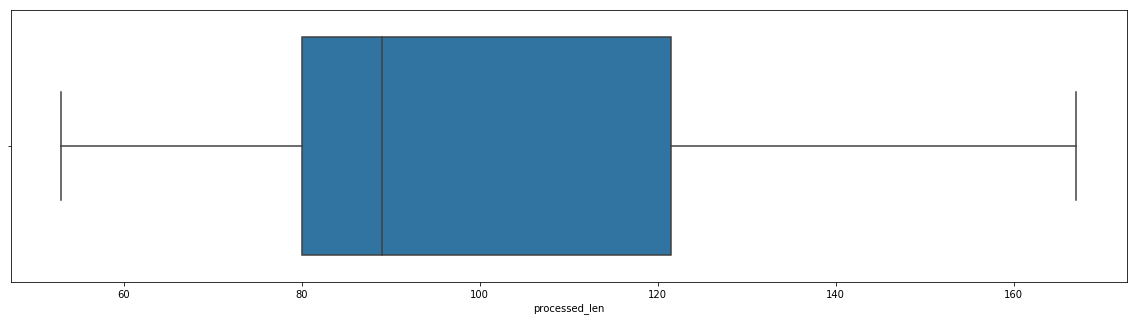

In [28]:
# overall distribution of tweet length
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(df['processed_len'])
plt.show()

### WordCloud

In [29]:
neg_tweets = df[df['sentiment'] == 'negative']
neg_string = []
for t in neg_tweets['message_text']:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

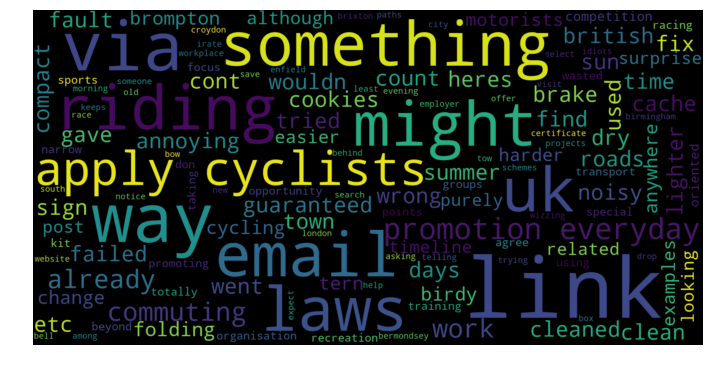

In [197]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

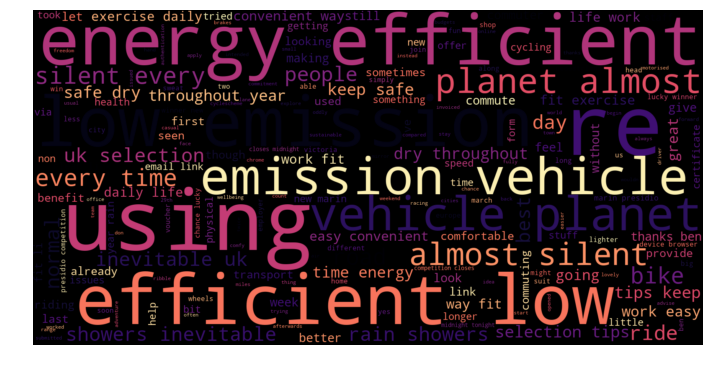

In [198]:
good_tweets = df[df['sentiment'] == 'positive']
good_string = []
for t in good_tweets['message_text']:
    good_string.append(t)
good_string = pd.Series(good_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(good_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(df['message_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [31]:
len(cvec.get_feature_names())

769

In [32]:
neg_doc_matrix = cvec.transform(df[df.sentiment == 'negative']['message_text'])
pos_doc_matrix = cvec.transform(df[df.sentiment == 'positive']['message_text'])
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [33]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
you,3,24,27
time,4,22,26
it,2,22,24
work,3,20,23
link,8,13,21
too,0,17,17
way,3,12,15
using,2,12,14
every,0,14,14
fit,0,14,14


Text(0.5, 1.0, 'Top 500 tokens in tweets')

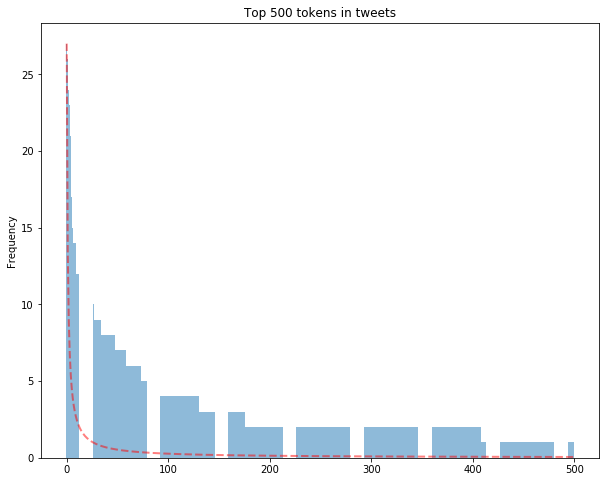

In [34]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

In [252]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**2)
plt.xlim(1,10**3)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

ValueError: Image size of 514x163446 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x432 with 1 Axes>

In [35]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

ValueError: Must pass 2-d input

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

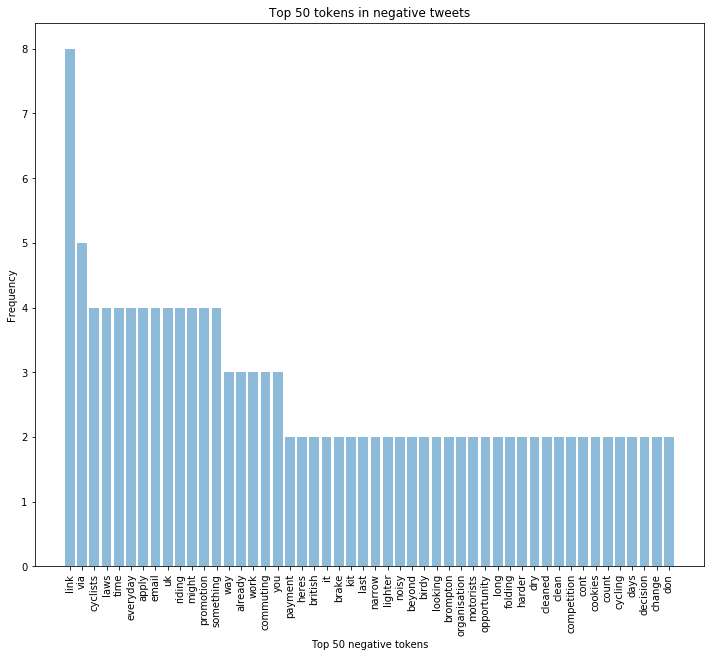

In [36]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

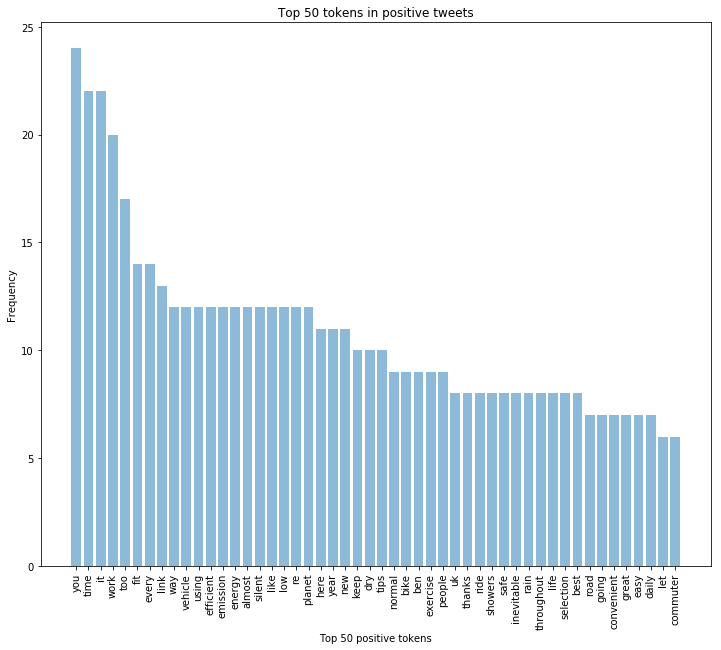

In [37]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

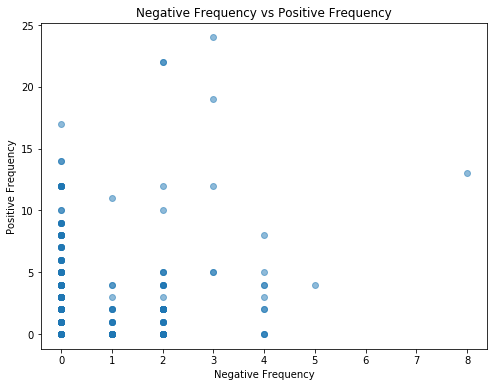

In [234]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [38]:
term_freq_df['pos_rate'] = term_freq_df['positive'] * 1./term_freq_df['total']
term_freq_df.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
little,0,4,4,1.0
promise,0,1,1,1.0
pics,0,1,1,1.0
planet,0,12,12,1.0
pleasant,0,1,1,1.0
plenty,0,1,1,1.0
plus,0,1,1,1.0
point,0,2,2,1.0
pollution,0,1,1,1.0
pop,0,1,1,1.0


In [39]:
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] * 1./term_freq_df['positive'].sum()
term_freq_df.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
you,3,24,27,0.888889,0.014833
time,4,22,26,0.846154,0.013597
it,2,22,24,0.916667,0.013597
work,3,20,23,0.869565,0.012361
too,0,17,17,1.000000,0.010507
fit,0,14,14,1.000000,0.008653
every,0,14,14,1.000000,0.008653
link,8,13,21,0.619048,0.008035
way,3,12,15,0.800000,0.007417
vehicle,0,12,12,1.000000,0.007417


In [40]:
df.head()

,created_at,favourites_count,followers_count,friends_count,retweet_count,sentiment,message_text,user_name,pre_clean_len,processed_len
0,2019-04-03 11:48:24,806,123,402,0,negative,"british summer time, might guaranteed sun dry ...",Open Scarborough,140,74
1,2019-04-02 16:54:02,2555,30937,6102,0,positive,"british summer time, might guaranteed sun dry ...",Cyclescheme,235,108
2,2019-04-02 16:53:02,186,257,972,5,positive,"energy efficient, low-emission vehicle planet....",ITGuyOnABike,140,86
3,2019-04-02 10:12:04,17302,3043,882,3,positive,rain showers inevitable uk. here’s selection t...,Cycle Northants,140,80
4,2019-04-02 09:23:42,208,137,203,3,positive,rain showers inevitable uk. here’s selection t...,UoYeco-nomical,140,80


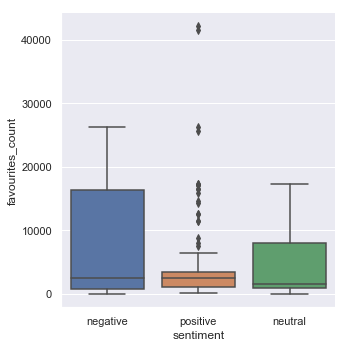

In [263]:
# how many tweets are liked by sentiment 
sns.set(rc={'figure.figsize':(20.7, 20.27)})
sns.catplot(x='sentiment', y='favourites_count', data=df, kind='box')

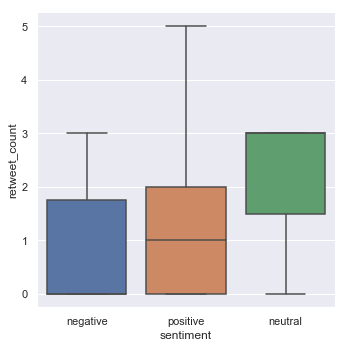

In [264]:
sns.catplot(x='user_name', y='retweet_count', data=df, kind='box')

In [110]:
df.sort_values('followers_count')

,created_at,favourites_count,followers_count,friends_count,retweet_count,sentiment,message_text,user_name,pre_clean_len,processed_len
24,2019-03-29 12:25:41,192,6,67,0,positive,"took long commute home last night, 2 counties ...",Gary,244,152
73,2019-04-01 08:46:15,12,30,111,0,negative,"reached decision time last scheme, long paymen...",James Harvey,163,66
99,2019-04-10 22:52:47,347,30,97,3,positive,"work easy, convenient way fit exercise daily l...",ian achurch,140,63
15,2019-04-01 08:46:15,12,30,112,0,negative,"reached decision time last scheme, long paymen...",James Harvey,163,66
43,2019-04-09 15:46:21,3444,31,97,2,positive,"work easy, convenient way fit exercise daily l...",Prinz_Rana,140,63
104,2019-04-09 15:46:21,3444,31,97,3,positive,"work easy, convenient way fit exercise daily l...",Prinz_Rana,140,63
128,2019-04-19 06:25:03,1989,44,187,0,positive,took year pedestrians corporation st city cent...,Daniel Smith,368,163
64,2019-04-02 08:03:04,101,55,186,5,positive,"energy efficient, low-emission vehicle planet....",Clare Boffey,140,86
6,2019-04-02 08:03:04,97,56,185,5,positive,"energy efficient, low-emission vehicle planet....",Clare Boffey,140,86
37,2019-03-25 10:18:10,24,57,121,0,negative,trying certificate via website. keeps asking s...,Caz Gates,165,75


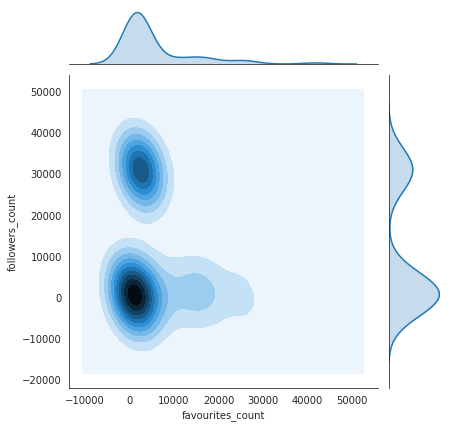

In [114]:
with sns.axes_style('white'):
    sns.jointplot('favourites_count', 'followers_count', df, kind='kde')

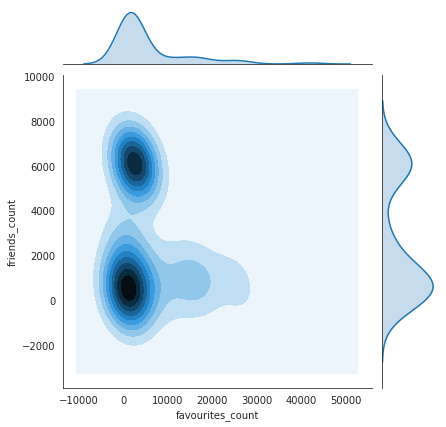

In [122]:
with sns.axes_style('white'):
    sns.jointplot('favourites_count', 'friends_count', df, kind='kde')

C:\Users\ljosh00-aa\AppData\Local\conda\conda\envs\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


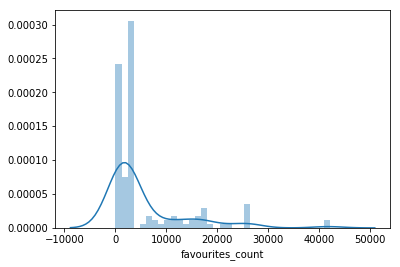

In [118]:
for col in 'x':
    sns.distplot(df['favourites_count'])

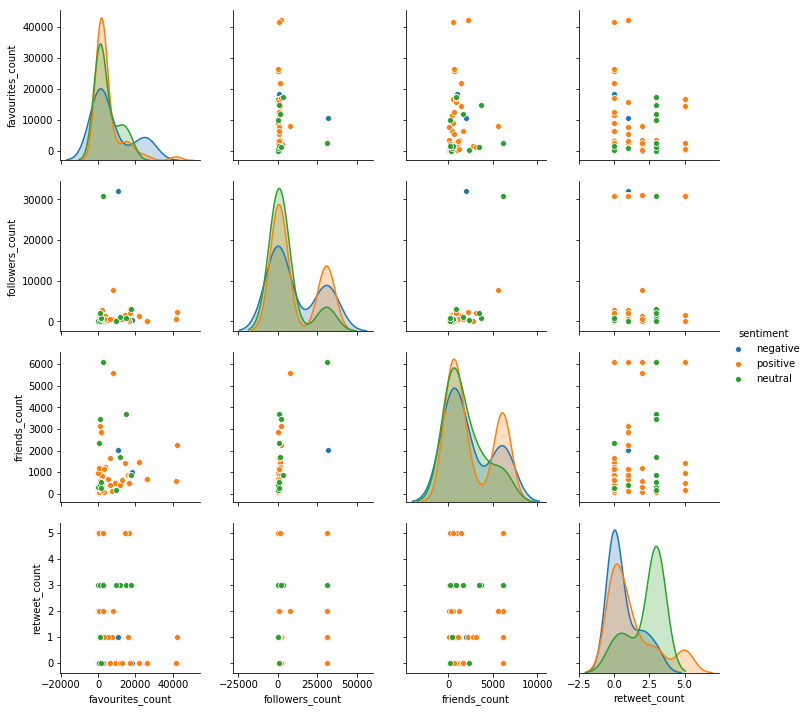

In [121]:
sns.pairplot(df.drop(columns=['pre_clean_len', 'processed_len']), hue='sentiment');

In [47]:
cs = df['user_name'] == 'Cyclescheme'

In [49]:
df_cs = df[cs]

In [98]:
df_cs.head()

,created_at,favourites_count,followers_count,friends_count,retweet_count,sentiment,message_text,user_name,pre_clean_len,processed_len
1,2019-04-02 16:54:02,2555,30937,6102,0,positive,"british summer time, might guaranteed sun dry ...",Cyclescheme,235,108
10,2019-04-02 06:49:02,2555,30937,6102,5,positive,"energy efficient, low-emission vehicle planet....",Cyclescheme,276,160
11,2019-04-01 17:38:01,2555,30937,6102,3,positive,rain showers inevitable uk. here’s selection t...,Cyclescheme,159,80
14,2019-04-01 14:41:16,2555,30937,6102,0,positive,"victoria, opened link submitted form without i...",Cyclescheme,181,103
17,2019-03-31 17:44:02,2555,30937,6102,1,positive,last chance lucky winner all-new marin presidi...,Cyclescheme,166,85


In [99]:
df_cs_grouped = df_cs.groupby(['sentiment']).agg({'mean', 'sum'})

In [103]:
df_cs_grouped.reset_index()

sentiment favourites_count        followers_count          friends_count  \
                        mean    sum            mean      sum          mean   
0  negative      2555.500000  15333    30908.500000   185451   6103.666667   
1   neutral      2555.500000   5111    30905.000000    61810   6103.500000   
2  positive      2555.486486  94553    30923.702703  1144177   6103.162162   

          retweet_count     pre_clean_len       processed_len        
      sum          mean sum          mean   sum          mean   sum  
0   36622      1.666667  10    201.500000  1209      90.50000   543  
1   12207      3.000000   6    184.000000   368      97.00000   194  
2  225817      1.027027  38    208.648649  7720     106.72973  3949

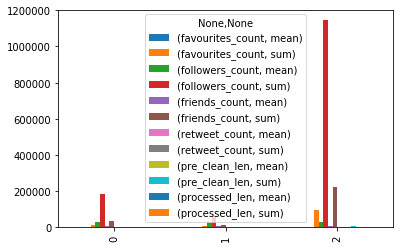

In [105]:
df_cs_grouped.reset_index().plot(kind='bar')
plt.show()